# <center>Image captioning model training

In [1]:
# Project imports
from src.net.model import Model
from src.data_processing.dataset import FlickrDataset, Collate
from src.data_processing.vocabulary import Vocabulary
from src.utils.predictor import Predictor
from src.utils.history import History
# Third party imports
import pandas as pd
import torch
import lightning as L
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
from lightning.pytorch.loggers import CSVLogger
from multiprocessing import cpu_count
torch.set_float32_matmul_precision('high')

# Project constants
NUM_WORKERS = cpu_count()
MAX_EPOCHS = 30
BATCH_SIZE = 64
IMGS_PATH = '/mnt/s/CV/COCO_2014/train2014'
CAPTIONS_PATH = '/mnt/s/CV/COCO_2014/cocotext.v2.json'
# Model hyperparametres
D_MODEL = 512
NUM_HEADS = 8
LR_START = 1e-4
GAMMA = 0.9

In [2]:
df = pd.read_json(CAPTIONS_PATH)
df

,cats,anns,imgs,imgToAnns,info
45346,NaN,"{'mask': [468.9, 286.7, 468.9, 295.2, 493.0, 2...",NaN,NaN,NaN
153036,NaN,"{'mask': [344.5, 261.5, 348.1, 261.5, 348.2, 2...",NaN,NaN,NaN
125303,NaN,"{'mask': [362.4, 280.9, 359.2, 286.3, 367.1, 2...",NaN,NaN,NaN
21639,NaN,"{'mask': [570.9, 9.6, 570.9, 14.3, 557.1, 14.3...",NaN,NaN,NaN
112792,NaN,"{'mask': [489.4, 131.8, 502.7, 135.6, 502.7, 1...",NaN,NaN,NaN
...,...,...,...,...,...
552204,NaN,NaN,"{'id': 552204, 'set': 'train', 'width': 500, '...","[178069, 178070, 178071, 178072]",NaN
360739,NaN,NaN,"{'id': 360739, 'set': 'val', 'width': 640, 'fi...",[],NaN
203249,NaN,NaN,"{'id': 203249, 'set': 'val', 'width': 340, 'fi...",[40045],NaN
571929,NaN,NaN,"{'id': 571929, 'set': 'train', 'width': 640, '...",[],NaN


In [3]:
anns = df[['anns']].dropna()
imgs = df[['imgs']].dropna()

df_dict = {
    'bbox': [],
    'image_id': [],
    'utf8_string': [],
}

imgs_dict = {
    'id': [],
    'width': [],
    'height': [],
    'file_name': []
}

for row in anns['anns']:
    for key in df_dict.keys():
        df_dict[key].append(row[key])
        
for row in imgs['imgs']:
    for key in imgs_dict.keys():
        imgs_dict[key].append(row[key])
        
annotations_df = pd.DataFrame(df_dict)
annotations_df = annotations_df[annotations_df['utf8_string'] != '']

imgs_df = pd.DataFrame(imgs_dict)

df = pd.merge(annotations_df, imgs_df, left_on='image_id', right_on='id', how='inner').drop(columns=['id', 'image_id'])
df['bbox'] = df['bbox'].apply(lambda x: np.array(x, dtype=int))
# Clip bboxes to image size
for i, row in df.iterrows():
    x, y, w, h = row['bbox']
    im_w, im_h = row['width'], row['height']
    x1 = np.clip(x, 0, im_w)
    x2 = np.clip(x1+w, 0, im_w)
    y1 = np.clip(y, 0, im_h)
    y2 = np.clip(y1+h, 0, im_h)
    df.at[i, 'bbox'] = np.array([x1, y1, x2, y2], dtype=int)

df.head()

,bbox,utf8_string,width,height,file_name
0,"[468, 286, 492, 295]",New,512,640,COCO_train2014_000000217925.jpg
1,"[342, 323, 382, 330]",royals.com,512,640,COCO_train2014_000000217925.jpg
2,"[309, 286, 326, 291]",NEW,512,640,COCO_train2014_000000217925.jpg
3,"[442, 292, 457, 299]",EAA,512,640,COCO_train2014_000000217925.jpg
4,"[203, 287, 226, 298]",New,512,640,COCO_train2014_000000217925.jpg


## Initialize vocabulary, datasets and dataloaders

In [4]:
vocab = Vocabulary(df['utf8_string'])

dataset_train = FlickrDataset(IMGS_PATH, df, vocab, 'train')
dataset_valid = FlickrDataset(IMGS_PATH, df, vocab, 'valid')
dataset_test = FlickrDataset(IMGS_PATH, df, vocab, 'test')

collate = Collate(pad_idx=vocab.word2idx['<PAD>'])
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate, num_workers=NUM_WORKERS)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate, num_workers=NUM_WORKERS)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate, num_workers=NUM_WORKERS)

print(f'Vocabulary size: {len(vocab)}')
print(f'Train size: {len(dataset_train)}')
print(f'Val/test size: {len(dataset_valid)}/{len(dataset_test)}')

Vocabulary size: 71
Train size: 67772
Val/test size: 3765/3766


## Configure model and callbacks

In [5]:
# Model
config = dict(
    vocab=vocab,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    lr_start=LR_START,
    gamma=GAMMA
)
model = Model(**config).cuda()
# Callbacks and logger
logger = CSVLogger('logs')
lr_monitor_callback = LearningRateMonitor(logging_interval='step')
checkpoint_callback = ModelCheckpoint(
    dirpath='weights',
    filename='checkpoint',
    save_weights_only=True,
    mode='min',
    monitor='val_CE'
)
early_stop_callback = EarlyStopping(
    monitor='val_CE',
    min_delta=0.05,
    patience=5,
    mode='min'
)

## Training

In [6]:
trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    enable_checkpointing=True,
    callbacks=[
        checkpoint_callback,
        lr_monitor_callback,
        early_stop_callback
    ], 
    logger=logger, 
    log_every_n_steps=len(dataloader_train) # Every epoch
)
trainer.fit(model=model, train_dataloaders=dataloader_train, val_dataloaders=dataloader_valid)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 59.2 M
1 | decoder | Decoder | 44.2 M
------------------------------------
45.3 M    Trainable params
58.1 M    Non-trainable params
103 M     Total params
413.625   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Evaluation on test set

In [7]:
trainer.test(model, dataloaders=dataloader_test, ckpt_path='weights/checkpoint.ckpt');

Restoring states from the checkpoint path at weights/checkpoint.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at weights/checkpoint.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_CE          │     1.807832956314087     │
└───────────────────────────┴───────────────────────────┘

## Load best checkpoint and draw history

In [8]:
model = model.__class__.load_from_checkpoint('weights/checkpoint.ckpt', vocab=vocab)

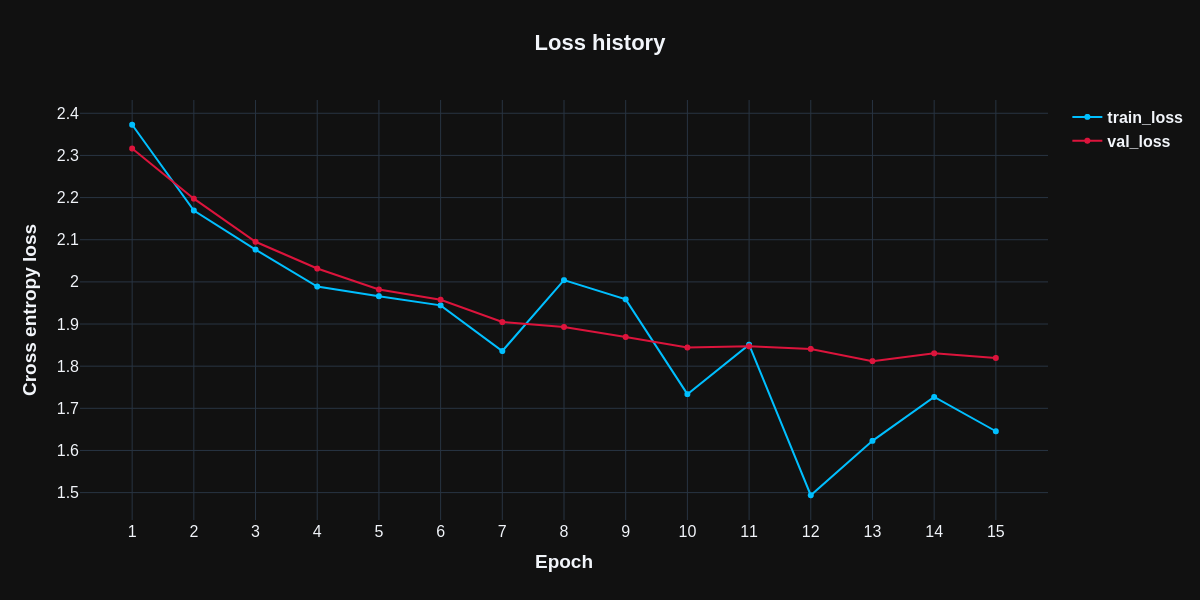

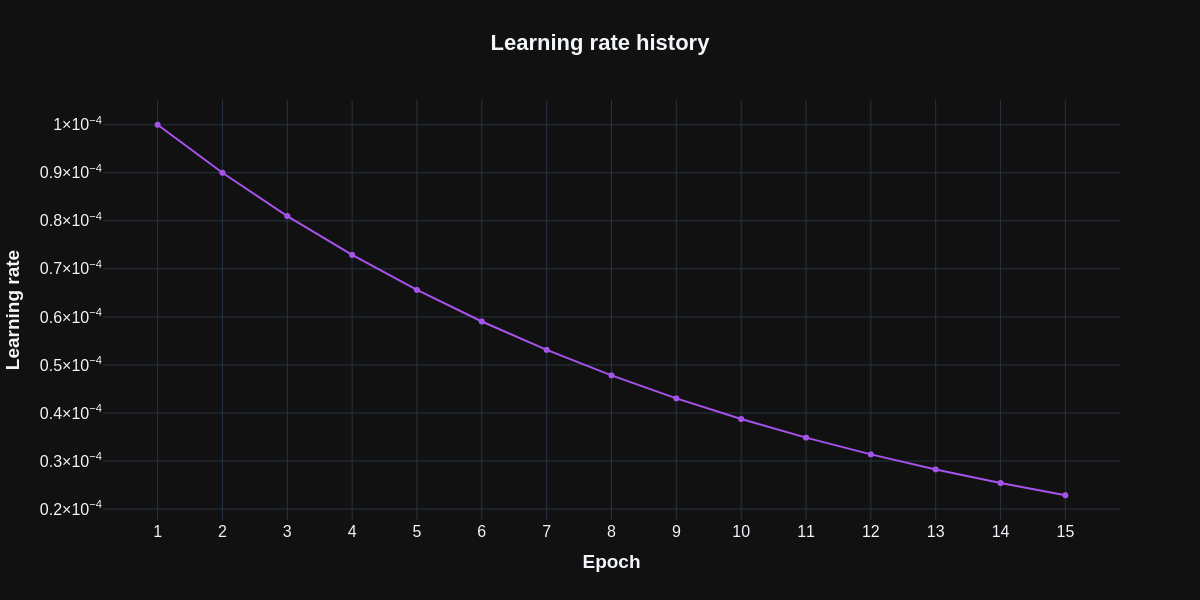

In [10]:
history_visualizer = History('logs/lightning_logs/version_5/metrics.csv')
history_visualizer.draw_history()

## Visualize predictions from test set

p a y


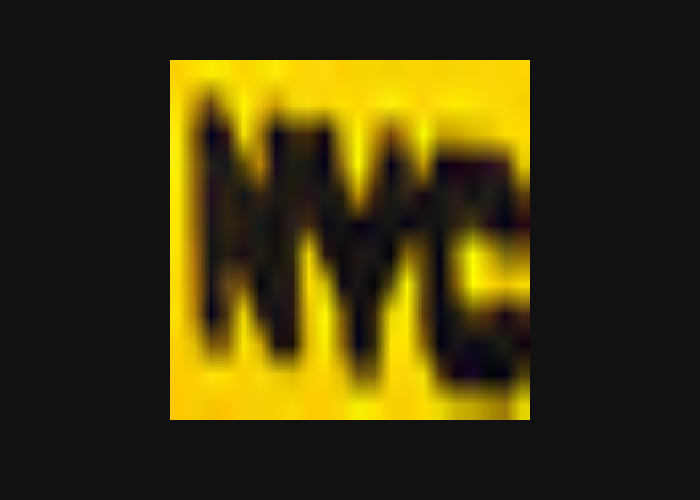

4 4 4


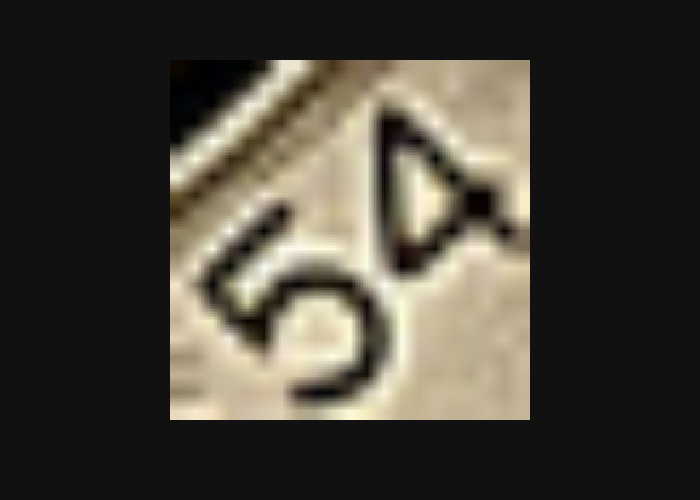

9


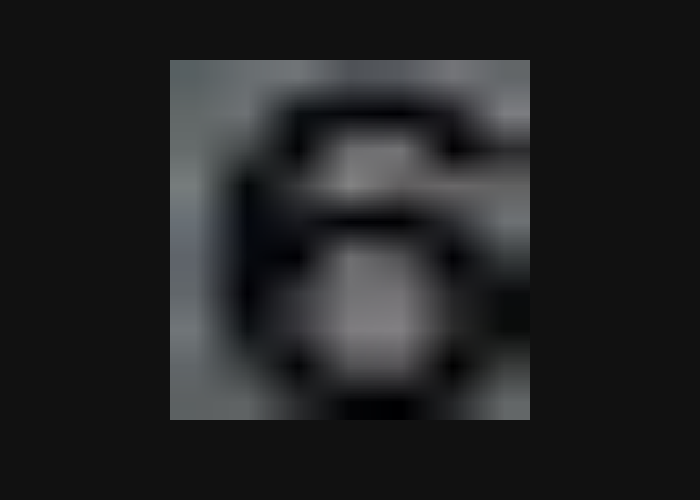

t h e


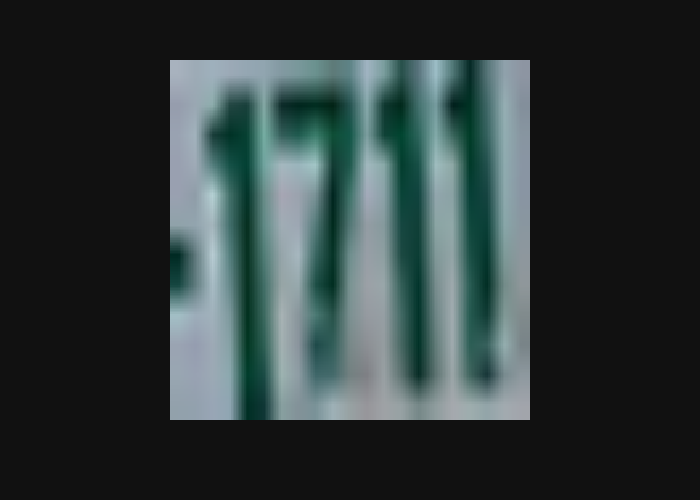

c o l d


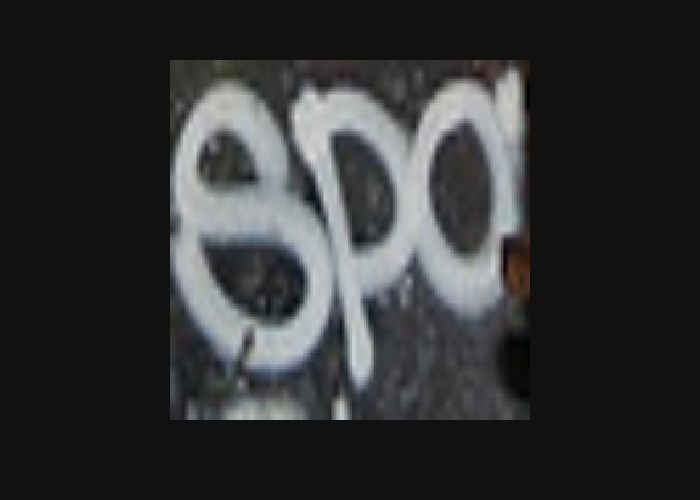

2 5 8


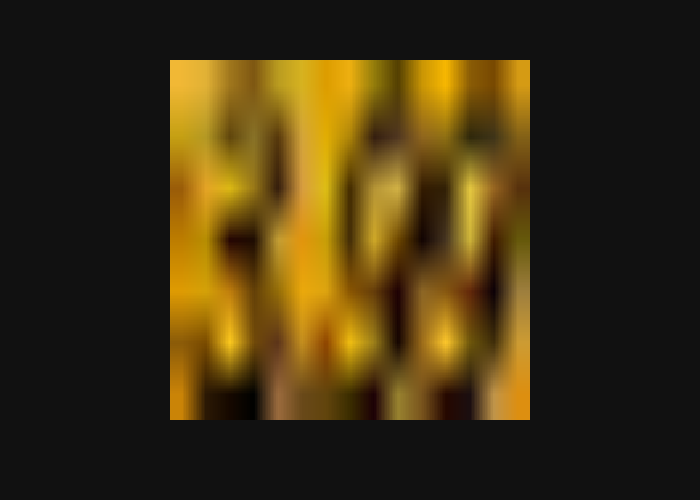

s t a r


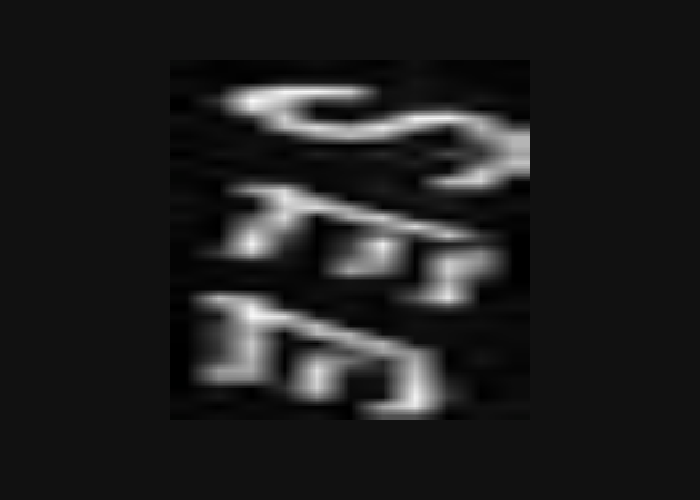

8


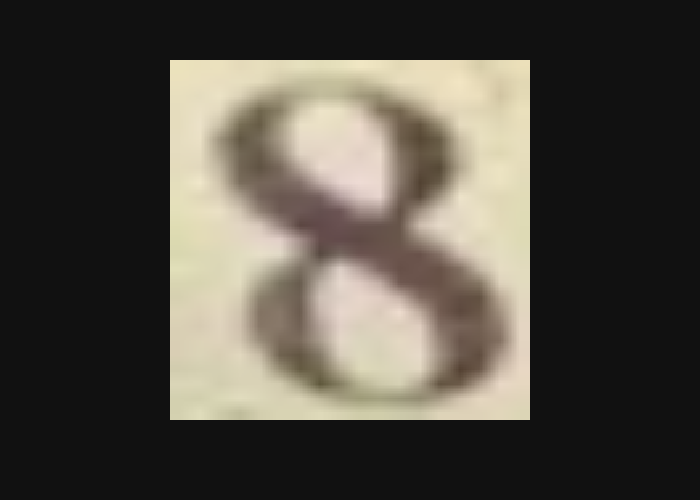

2 4


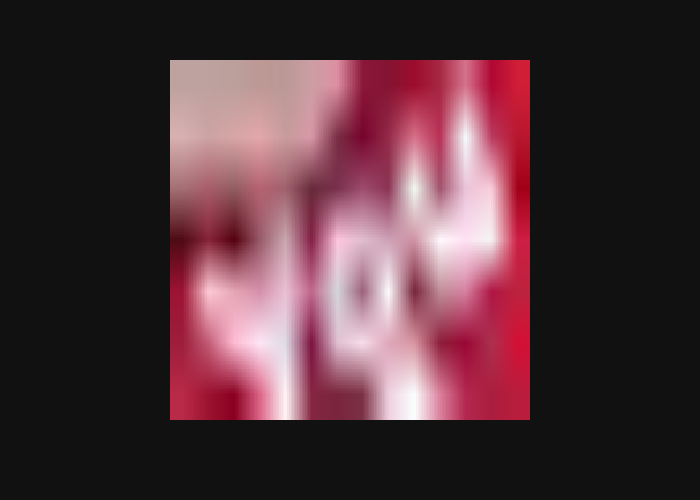

o f


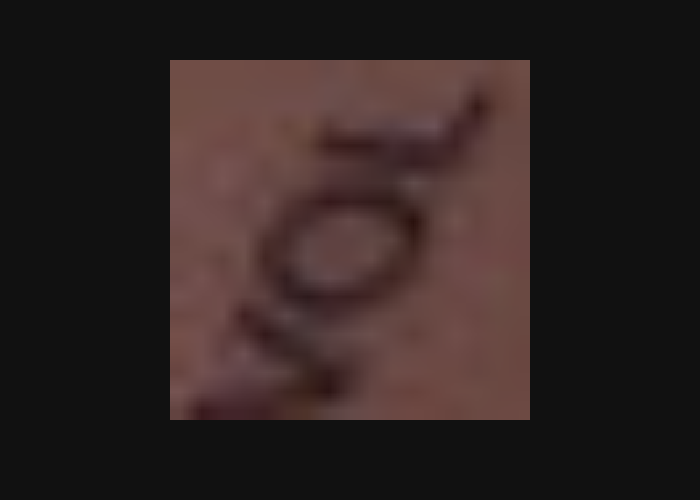

In [13]:
predictions_visuazlier = Predictor()
predictions_visuazlier.caption_dataloader(dataloader=dataloader_train, model=model, n_samples=10)